2025-06-24 19:45:06,561 - INFO - Iniciando comparación...
2025-06-24 19:45:06,563 - INFO - n=  1 | Gauss:        3 ops (0.0000s) | Jordan:        2 ops (0.0000s)
2025-06-24 19:45:06,566 - INFO - n=  6 | Gauss:      233 ops (0.0010s) | Jordan:      297 ops (0.0010s)
2025-06-24 19:45:06,568 - INFO - n= 11 | Gauss:     1188 ops (0.0000s) | Jordan:     1617 ops (0.0010s)
2025-06-24 19:45:06,571 - INFO - n= 16 | Gauss:     3368 ops (0.0000s) | Jordan:     4712 ops (0.0010s)
2025-06-24 19:45:06,576 - INFO - n= 21 | Gauss:     7273 ops (0.0030s) | Jordan:    10332 ops (0.0010s)
2025-06-24 19:45:06,582 - INFO - n= 26 | Gauss:    13403 ops (0.0020s) | Jordan:    19227 ops (0.0020s)
2025-06-24 19:45:06,591 - INFO - n= 31 | Gauss:    22258 ops (0.0030s) | Jordan:    32147 ops (0.0040s)
2025-06-24 19:45:06,600 - INFO - n= 36 | Gauss:    34338 ops (0.0030s) | Jordan:    49842 ops (0.0040s)
2025-06-24 19:45:06,614 - INFO - n= 41 | Gauss:    50143 ops (0.0040s) | Jordan:    73062 ops (0.0080s)
2025-0

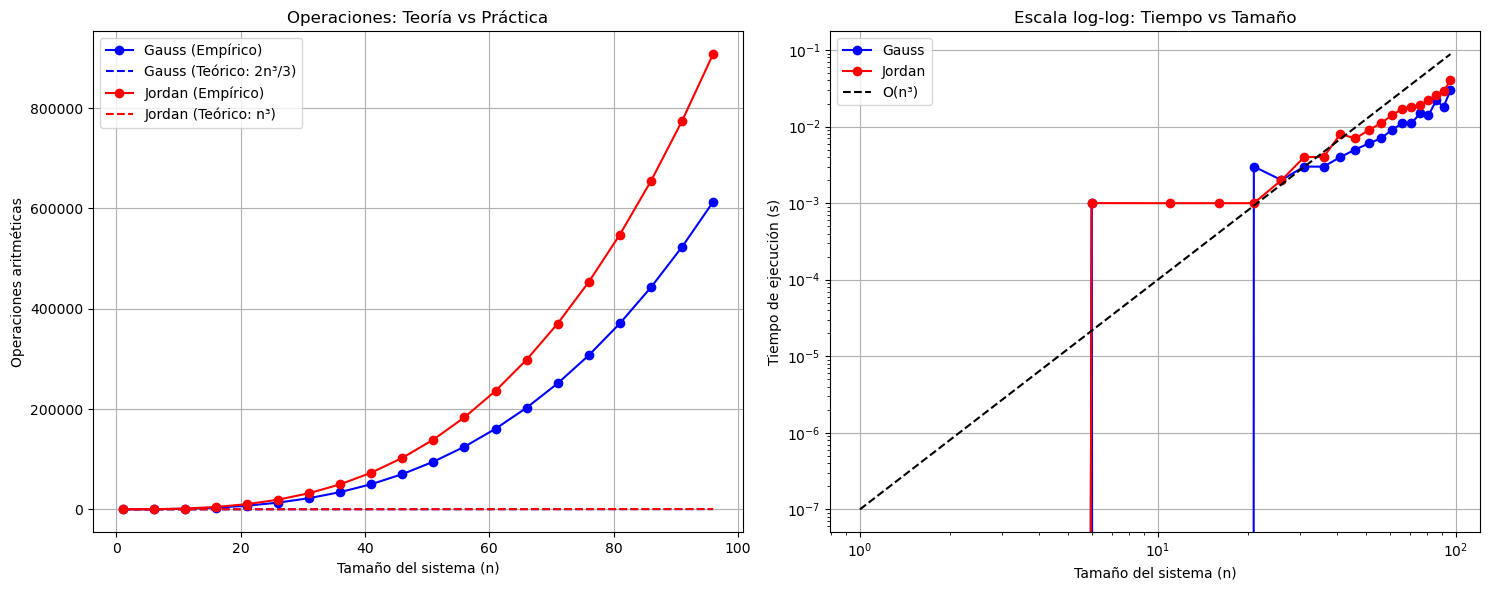

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Tuple, Dict
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def matriz_aumentada(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Crea la matriz aumentada [A|b]."""
    return np.column_stack((A, b))

def eliminacion_gaussiana(Ab: np.ndarray) -> Tuple[np.ndarray, int]:
    """Implementación de Eliminación Gaussiana con conteo de operaciones."""
    n = Ab.shape[0]
    operaciones = 0
    
    # Fase de eliminación
    for i in range(n-1):
        # Pivoteo parcial (no contamos como operación aritmética)
        max_row = i + np.argmax(np.abs(Ab[i:, i]))
        if Ab[max_row, i] == 0:
            raise ValueError("Sistema singular")
        if max_row != i:
            Ab[[i, max_row]] = Ab[[max_row, i]]
        
        # Eliminación
        for j in range(i+1, n):
            m = Ab[j, i] / Ab[i, i]
            operaciones += 1  # División
            
            Ab[j, i:] -= m * Ab[i, i:]
            operaciones += 2 * (n - i + 1)  # Multiplicación y resta para cada elemento
    
    # Sustitución hacia atrás
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (Ab[i, -1] - np.dot(Ab[i, i+1:n], x[i+1:n])) / Ab[i, i]
        operaciones += 2*(n - i) + 1  # Producto punto (n-i operaciones), resta y división
    
    return x, operaciones

def gauss_jordan(Ab: np.ndarray) -> Tuple[np.ndarray, int]:
    """Implementación de Gauss-Jordan con conteo de operaciones."""
    n = Ab.shape[0]
    operaciones = 0
    
    for i in range(n):
        # Pivoteo parcial
        max_row = i + np.argmax(np.abs(Ab[i:, i]))
        if Ab[max_row, i] == 0:
            raise ValueError("Sistema singular")
        if max_row != i:
            Ab[[i, max_row]] = Ab[[max_row, i]]
        
        # Normalización
        pivot = Ab[i, i]
        Ab[i] /= pivot
        operaciones += n - i + 1  # Divisiones
        
        # Eliminación
        for j in range(n):
            if j != i:
                factor = Ab[j, i]
                Ab[j] -= factor * Ab[i]
                operaciones += 2 * (n - i + 1)  # Multiplicación y resta
    
    return Ab[:, -1], operaciones

def comparar_metodos(n_max: int = 100, step: int = 5) -> Tuple[Dict, Dict]:
    """Compara ambos métodos experimentalmente."""
    resultados_gauss = {'n': [], 'tiempo': [], 'operaciones': [], 'teoria': []}
    resultados_jordan = {'n': [], 'tiempo': [], 'operaciones': [], 'teoria': []}
    
    for n in range(1, n_max+1, step):
        try:
            # Generar sistema diagonal dominante para buen condicionamiento
            A = np.random.rand(n, n) + n*np.eye(n)
            b = np.random.rand(n)
            Ab = matriz_aumentada(A, b)
            
            # Eliminación Gaussiana
            start = time.time()
            _, ops_gauss = eliminacion_gaussiana(Ab.copy())
            t_gauss = time.time() - start
            
            # Gauss-Jordan
            start = time.time()
            _, ops_jordan = gauss_jordan(Ab.copy())
            t_jordan = time.time() - start
            
            # Guardar resultados
            resultados_gauss['n'].append(n)
            resultados_gauss['tiempo'].append(t_gauss)
            resultados_gauss['operaciones'].append(ops_gauss)
            resultados_gauss['teoria'].append(2/3 * n*3 + 3/2 * n*2)  # 2n³/3 + O(n²)
            
            resultados_jordan['n'].append(n)
            resultados_jordan['tiempo'].append(t_jordan)
            resultados_jordan['operaciones'].append(ops_jordan)
            resultados_jordan['teoria'].append(n*3 + 2*n*2)  # n³ + O(n²)
            
            logging.info(f"n={n:3d} | Gauss: {ops_gauss:8d} ops ({t_gauss:.4f}s) | "
                        f"Jordan: {ops_jordan:8d} ops ({t_jordan:.4f}s)")
            
        except Exception as e:
            logging.error(f"Error en n={n}: {str(e)}")
            break
    
    return resultados_gauss, resultados_jordan

def graficar_resultados(gauss: Dict, jordan: Dict):
    """Genera gráficos comparativos con teoría y práctica."""
    plt.figure(figsize=(15, 6))
    
    # Gráfico 1: Operaciones teóricas vs empíricas
    plt.subplot(1, 2, 1)
    n_vals = np.array(gauss['n'])
    
    plt.plot(n_vals, gauss['operaciones'], 'bo-', label='Gauss (Empírico)')
    plt.plot(n_vals, gauss['teoria'], 'b--', label='Gauss (Teórico: 2n³/3)')
    plt.plot(n_vals, jordan['operaciones'], 'ro-', label='Jordan (Empírico)')
    plt.plot(n_vals, jordan['teoria'], 'r--', label='Jordan (Teórico: n³)')
    
    plt.xlabel('Tamaño del sistema (n)')
    plt.ylabel('Operaciones aritméticas')
    plt.title('Operaciones: Teoría vs Práctica')
    plt.legend()
    plt.grid(True)
    
    # Gráfico 2: Tiempos de ejecución
    plt.subplot(1, 2, 2)
    plt.loglog(n_vals, gauss['tiempo'], 'bo-', label='Gauss')
    plt.loglog(n_vals, jordan['tiempo'], 'ro-', label='Jordan')
    plt.loglog(n_vals, 1e-7 * n_vals**3, 'k--', label='O(n³)')
    
    plt.xlabel('Tamaño del sistema (n)')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Escala log-log: Tiempo vs Tamaño')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    np.random.seed(42)  # Para reproducibilidad
    
    logging.info("Iniciando comparación...")
    gauss, jordan = comparar_metodos(n_max=100, step=5)
    
    logging.info("Generando gráficos...")
    graficar_resultados(gauss, jordan)
